In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import math
from sklearn.preprocessing import StandardScaler
import random
import wandb
import os
device = torch.device("cuda:0")

### 1、 加载数据集并进行处理

#### 1.1 读取数据集

In [2]:
train_dataset = pd.read_csv("train_data.csv")
test_dataset = pd.read_csv("test_data.csv")
train_dataset.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1.0,2011/1/1,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,3.0,13.0,16.0
1,2.0,2011/1/1,1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,8.0,32.0,40.0
2,3.0,2011/1/1,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,5.0,27.0,32.0
3,4.0,2011/1/1,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,3.0,10.0,13.0
4,5.0,2011/1/1,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,0.0,1.0,1.0


#### 1.2 处理数据集

In [3]:
#对天气以及季节进行编码（季节变为0-3，天气变为0-2）
# season_encoder = LabelEncoder()
# train_dataset['season'] = season_encoder.fit_transform(train_dataset['season'])
# test_dataset['season'] = season_encoder.fit_transform(train_dataset['season'])
# weathersit_encoder = LabelEncoder()
# train_dataset['weathersit'] = weathersit_encoder.fit_transform(train_dataset['weathersit'])

#通过sin和cos编码周期性特征
#季节编码
train_dataset['season_sin'] = np.sin(2 * np.pi * train_dataset['season'] / 4)
train_dataset['season_cos'] = np.cos(2 * np.pi * train_dataset['season'] / 4)
test_dataset['season_sin'] = np.sin(2 * np.pi * test_dataset['season'] / 4)
test_dataset['season_cos'] = np.cos(2 * np.pi * test_dataset['season'] / 4)
#月份编码
train_dataset['month_sin'] = np.sin(2 * np.pi * train_dataset['mnth'] / 12)
train_dataset['month_cos'] = np.cos(2 * np.pi * train_dataset['mnth'] / 12)
test_dataset['month_sin'] = np.sin(2 * np.pi * test_dataset['mnth'] / 12)
test_dataset['month_cos'] = np.cos(2 * np.pi * test_dataset['mnth'] / 12)
#工作日编码
train_dataset['weekday_sin'] = np.sin(2 * np.pi * train_dataset['weekday'] / 7)
train_dataset['weekday_cos'] = np.cos(2 * np.pi * train_dataset['weekday'] / 7)
test_dataset['weekday_sin'] = np.sin(2 * np.pi * test_dataset['weekday'] / 7)
test_dataset['weekday_cos'] = np.cos(2 * np.pi * test_dataset['weekday'] / 7)
#小时编码
train_dataset['hour_sin'] = np.sin(2 * np.pi * train_dataset['hr'] / 24)
train_dataset['hour_cos'] = np.cos(2 * np.pi * train_dataset['hr'] / 24)
test_dataset['hour_sin'] = np.sin(2 * np.pi * test_dataset['hr'] / 24)
test_dataset['hour_cos'] = np.cos(2 * np.pi * test_dataset['hr'] / 24)

# 对训练集特征进行标准化
scaler = StandardScaler()
features = ['yr', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 
            'season_sin', 'season_cos', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']
train_dataset[features] = scaler.fit_transform(train_dataset[features])
#创建滑动窗口
def create_timeseries_data(df, window_size=96, forecast_horizon=96):
    X, y = [], []       #两个数组用于保存值
    for i in range(window_size, len(df) - forecast_horizon + 1):
        # X.append(df.iloc[i-window_size:i, 2:].values)  
        # 过去96小时的数据
        #['mnth','holiday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']   8特征值
        X.append(df.iloc[i-window_size:i][['yr', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'season_sin', 'season_cos', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']].values)
        y.append(df.iloc[i:i + forecast_horizon]['cnt'].values)    #待预测的未来96小时的cnt
    return np.array(X), np.array(y)

# 创建96小时的时间窗口数据
X, y = create_timeseries_data(train_dataset, window_size=96, forecast_horizon=240)
X_test, y_test =  create_timeseries_data(test_dataset, window_size=96, forecast_horizon=240)

#### 1.3 划分数据集

In [4]:
train_size = int(len(X) * 0.99)
val_size = int(len(X) * 0.05)

X_train, X_val = X[:train_size], X[train_size:train_size+val_size]
y_train, y_val = y[:train_size], y[train_size:train_size+val_size]

X_test = X_test[:train_size]
y_test = y_test[:train_size]
# X_train = X
# y_train = y

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

if np.any(np.isnan(y_test)):
    print("y_true contains NaN values")

(14735, 96, 16) (14735, 240)
(149, 96, 16) (149, 240)


In [5]:
print(X_train[0][0])
print(X_train.dtype)
print(y_train.dtype)

[-0.87183286 -0.16536185 -1.47421353 -0.64597027 -1.39216395 -1.15191222
  0.94545653 -1.56519255  1.38671423  0.20965553  0.61473259  1.44825643
 -1.1023499   0.87615709  0.0060855   1.41836036]
float64
float64


### 2、构建Dataloader

In [6]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)


X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

b_size = 128
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=b_size)
test_loader = DataLoader(test_dataset, batch_size=b_size)


In [7]:
# print(len(val_loader))
print(len(train_dataset))
print(y_test[0])
# print(len(val_dataset))

14735
[785 384 260 304 468 424 400 470 634 900 761 500 372 267 264 171 191 141
  75  56  11  10  30  84 206 395 539 647 743 710 576 620 659 610 495 341
 247 215 185 179 127 109  74  22  11  10  23  35  62  86 185 336 392 320
 314 306 333 157 106 114 116 113  79  80  51  37  15  10   7  19  59 154
 397 332 298 308 341 405 420 370 377 497 456 371 227 151 107  69  31  13
   7   3   7  19 143 362 713 382 164 193 260 238 244 254 424 806 784 514
 360 225 162  84  33   8   8   6   6  40 175 507 839 366 217 291 390 297
 271 319 566 948 844 566 392 269 197 136  42  11  11   3  10  42 159 478
 798 355 204 251 326 291 348 460 481 827 692 743 415 260 177 186  68  37
  16   6   8  35 143 392 745 400 275 313 387 381 371 455 520 837 642 493
 308 190 160 100 249 146  67  15  11  11  28  70 174 266 347 527 573 670
 597 615 637 528 473 332 255 204 189 125 111 112  66  28  12  11  24  51
 132 223 428 494 562 619 617 568 581 539 453 336 246 196 125 105  48  29
   6   4  10  40 147 476]


### 3、定义Transformer结构

In [8]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_len, output_dim, nhead=4, num_encoder_layers=6, dim_feedforward=512):
        super(TransformerModel, self).__init__()
        
        # Transformer Encoder
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=input_dim, 
                nhead=nhead, 
                dim_feedforward=dim_feedforward, 
                batch_first=True  # 启用 batch_first
            ), 
            num_layers=num_encoder_layers
        )
        
        # Fully connected layer for output prediction
        self.fc = nn.Linear(input_dim, output_dim)  # output_dim should be the forecast horizon (96 in your case)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim), batch_first=True, so no need for permute
        # Pass through the transformer encoder
        transformer_out = self.encoder(x)
        
        # Taking the output of the last time step for prediction
        # Here, we want to get predictions for all future 96 hours
        output = transformer_out[:, -1, :]  # This is the representation of the last time step
        
        # Fully connected layer to produce the output for all 96 hours (forecast_horizon)
        output = self.fc(output)  # The output should now have shape (batch_size, forecast_horizon)
        return output
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)
    
#     def forward(self, x):
#         return x + self.pe[:x.size(0), :]

# class TransformerModel(nn.Module):
#     def __init__(self, input_dim, seq_len, output_dim, nhead=8, num_encoder_layers=6, dropout=0.1):
#         super(TransformerModel, self).__init__()
        
#         # Position encoding
#         self.pos_encoder = PositionalEncoding(input_dim)
        
#         # Transformer Encoder
#         self.encoder_layer = nn.TransformerEncoderLayer(
#             d_model=input_dim, 
#             nhead=nhead, 
#             dropout=dropout
#         )
#         self.transformer_encoder = nn.TransformerEncoder(
#             self.encoder_layer, 
#             num_layers=num_encoder_layers
#         )
        
#         # Fully connected layer for output prediction
#         self.fc = nn.Linear(input_dim, output_dim)  # Output size = forecast horizon (96)
    
#     def forward(self, x):
#         # x shape: (batch_size, seq_len, input_dim)
#         x = x.permute(1, 0, 2)  # (seq_len, batch_size, input_dim) for transformer
        
#         # Add positional encoding
#         x = self.pos_encoder(x)
        
#         # Pass through the transformer encoder
#         transformer_out = self.transformer_encoder(x)
        
#         # Flatten the output and pass through the fully connected layer
#         output = transformer_out[-1, :, :]  # Get the output from the last time step
#         output = self.fc(output)  # Output size: (batch_size, output_dim)
#         return output

# Model instance
model = TransformerModel(input_dim=X_train.shape[2], seq_len=X_train.shape[1], output_dim=y_train.shape[1]).to(device)

### 4、定义训练过程

#### 4.1、wandb初始化

In [9]:
wandb.init(project="Transformer-bike-240", name="5", config={
    "epochs": 1000,
    "batch_size": 128,
    "learning_rate": 2e-4,
    "initial" : "random",
    "nhead" : 4,
    "features" : 16,
    "layer" : 6
})
torch.cuda.empty_cache()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tsjsjym (tsjsjym-soochow-university). Use `wandb login --relogin` to force relogin


In [10]:
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

save_path = "./results/checkpoints_240/5"
os.makedirs(save_path, exist_ok=True)
# 训练循环
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # 在每个epoch开始时创建一个进度条
    progress_bar_epoch = tqdm(total=1, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=True, mininterval=1.0)
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.float().to(device), targets.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 记录每个batch的loss
        wandb.log({"train_loss": loss.item(), "step": batch_idx})
    
    # 记录并更新每个epoch的总loss
    wandb.log({"total_train_loss": running_loss / len(train_loader), "epoch": epoch+1})

    # 每过40个epoch保存一次模型
    if epoch % 40 == 0:
        checkpoint_path = os.path.join(save_path, f"checkpoint_epoch{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path)

    # 更新 epoch 进度条的状态
    progress_bar_epoch.update(1)  # 完成当前 epoch

    # 打印当前 epoch 的损失
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

Epoch 1/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1000, Loss: 64871.35721982759


Epoch 2/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/1000, Loss: 64663.15035695043


Epoch 3/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/1000, Loss: 64581.25761045259


Epoch 4/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/1000, Loss: 64163.94494207974


Epoch 5/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/1000, Loss: 64325.63439520474


Epoch 6/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/1000, Loss: 63924.998619342674


Epoch 7/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/1000, Loss: 63629.843884698275


Epoch 8/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/1000, Loss: 63242.74740705819


Epoch 9/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/1000, Loss: 62910.2183122306


Epoch 10/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/1000, Loss: 62413.089372306036


Epoch 11/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/1000, Loss: 62268.624427532326


Epoch 12/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/1000, Loss: 62002.507071659486


Epoch 13/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/1000, Loss: 61380.50548895474


Epoch 14/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/1000, Loss: 61002.19598599138


Epoch 15/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/1000, Loss: 60637.29007273707


Epoch 16/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/1000, Loss: 60058.31074892241


Epoch 17/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/1000, Loss: 59646.203360721986


Epoch 18/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/1000, Loss: 59032.568359375


Epoch 19/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/1000, Loss: 58727.855603448275


Epoch 20/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/1000, Loss: 58097.26919450431


Epoch 21/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/1000, Loss: 57569.14129849138


Epoch 22/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/1000, Loss: 57051.41473599138


Epoch 23/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/1000, Loss: 56571.31327451509


Epoch 24/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/1000, Loss: 55971.8617658944


Epoch 25/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/1000, Loss: 55478.57879849138


Epoch 26/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/1000, Loss: 54980.2348127694


Epoch 27/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/1000, Loss: 54443.47629310345


Epoch 28/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/1000, Loss: 53809.96083647629


Epoch 29/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/1000, Loss: 53205.26336880388


Epoch 30/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/1000, Loss: 52836.85530037715


Epoch 31/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/1000, Loss: 52107.09678071121


Epoch 32/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/1000, Loss: 51511.04219423491


Epoch 33/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/1000, Loss: 51092.0932112069


Epoch 34/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/1000, Loss: 50534.1489762931


Epoch 35/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/1000, Loss: 49897.41487068965


Epoch 36/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/1000, Loss: 49300.29037580819


Epoch 37/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/1000, Loss: 48815.63688712285


Epoch 38/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/1000, Loss: 48179.82327586207


Epoch 39/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/1000, Loss: 47639.7451171875


Epoch 40/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/1000, Loss: 47252.837654903014


Epoch 41/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/1000, Loss: 46497.2113752694


Epoch 42/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/1000, Loss: 46094.39783135776


Epoch 43/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/1000, Loss: 45499.688712284486


Epoch 44/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/1000, Loss: 44791.38047211746


Epoch 45/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/1000, Loss: 44408.917227909486


Epoch 46/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/1000, Loss: 43859.94426858836


Epoch 47/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/1000, Loss: 43297.91473599138


Epoch 48/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/1000, Loss: 42839.08853044181


Epoch 49/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/1000, Loss: 42282.68618669181


Epoch 50/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/1000, Loss: 41747.20127289871


Epoch 51/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/1000, Loss: 41351.234779094826


Epoch 52/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/1000, Loss: 40812.64114695582


Epoch 53/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/1000, Loss: 40255.980334051725


Epoch 54/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/1000, Loss: 39759.9431404903


Epoch 55/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/1000, Loss: 39269.88397427263


Epoch 56/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/1000, Loss: 38918.030677532326


Epoch 57/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/1000, Loss: 38415.4260001347


Epoch 58/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/1000, Loss: 37956.324353448275


Epoch 59/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/1000, Loss: 37586.0832266972


Epoch 60/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/1000, Loss: 37132.92421538254


Epoch 61/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/1000, Loss: 36679.18047885237


Epoch 62/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/1000, Loss: 36274.93918372845


Epoch 63/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/1000, Loss: 35859.859290813576


Epoch 64/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/1000, Loss: 35335.27143386315


Epoch 65/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/1000, Loss: 35062.17825633082


Epoch 66/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/1000, Loss: 34726.39483432112


Epoch 67/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/1000, Loss: 34270.64880792026


Epoch 68/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/1000, Loss: 33925.852943157326


Epoch 69/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/1000, Loss: 33623.4634294181


Epoch 70/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/1000, Loss: 33266.103919719826


Epoch 71/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/1000, Loss: 33057.849137931036


Epoch 72/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/1000, Loss: 32727.001700565732


Epoch 73/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/1000, Loss: 32354.194133890087


Epoch 74/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/1000, Loss: 31977.101444639007


Epoch 75/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/1000, Loss: 31832.124747440732


Epoch 76/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/1000, Loss: 31527.757189520475


Epoch 77/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/1000, Loss: 31173.02389210668


Epoch 78/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/1000, Loss: 30984.497356546337


Epoch 79/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/1000, Loss: 30722.450026939656


Epoch 80/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/1000, Loss: 30547.143941945043


Epoch 81/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/1000, Loss: 30227.16958512931


Epoch 82/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/1000, Loss: 30040.994393184268


Epoch 83/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/1000, Loss: 29836.231058054957


Epoch 84/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/1000, Loss: 29627.322821255388


Epoch 85/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/1000, Loss: 29409.812432650862


Epoch 86/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/1000, Loss: 29269.408405172413


Epoch 87/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/1000, Loss: 29139.317753232757


Epoch 88/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/1000, Loss: 28912.142948545257


Epoch 89/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/1000, Loss: 28742.75631398168


Epoch 90/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/1000, Loss: 28611.338614628232


Epoch 91/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/1000, Loss: 28476.456425107757


Epoch 92/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/1000, Loss: 28239.030172413793


Epoch 93/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/1000, Loss: 28191.919635641163


Epoch 94/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/1000, Loss: 27993.134479391163


Epoch 95/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/1000, Loss: 27834.182263604525


Epoch 96/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/1000, Loss: 27684.114459859913


Epoch 97/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/1000, Loss: 27551.07110385237


Epoch 98/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/1000, Loss: 27450.019548087286


Epoch 99/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/1000, Loss: 27234.209236934268


Epoch 100/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/1000, Loss: 27185.81903286638


Epoch 101/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 101/1000, Loss: 27056.664466594826


Epoch 102/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 102/1000, Loss: 26857.084051724138


Epoch 103/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 103/1000, Loss: 26733.42184132543


Epoch 104/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 104/1000, Loss: 26651.100165005388


Epoch 105/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 105/1000, Loss: 26439.879714439656


Epoch 106/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 106/1000, Loss: 26446.31711341595


Epoch 107/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 107/1000, Loss: 26280.977555899786


Epoch 108/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 108/1000, Loss: 26173.445783943964


Epoch 109/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 109/1000, Loss: 25973.338884024786


Epoch 110/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 110/1000, Loss: 25794.668137122844


Epoch 111/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 111/1000, Loss: 25688.280071390087


Epoch 112/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 112/1000, Loss: 25554.85806169181


Epoch 113/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 113/1000, Loss: 25476.92825633082


Epoch 114/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 114/1000, Loss: 25289.672918911638


Epoch 115/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 115/1000, Loss: 25213.338783001076


Epoch 116/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 116/1000, Loss: 24995.354424838362


Epoch 117/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 117/1000, Loss: 24890.411503232757


Epoch 118/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 118/1000, Loss: 24781.147662984913


Epoch 119/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 119/1000, Loss: 24627.412968076507


Epoch 120/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 120/1000, Loss: 24483.364981815732


Epoch 121/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 121/1000, Loss: 24328.114661907326


Epoch 122/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 122/1000, Loss: 24189.080734779094


Epoch 123/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 123/1000, Loss: 24033.207839439656


Epoch 124/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 124/1000, Loss: 23896.297464304957


Epoch 125/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 125/1000, Loss: 23764.823191675645


Epoch 126/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 126/1000, Loss: 23541.811422413793


Epoch 127/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 127/1000, Loss: 23476.371632543105


Epoch 128/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 128/1000, Loss: 23226.290358970906


Epoch 129/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 129/1000, Loss: 23118.22848195043


Epoch 130/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 130/1000, Loss: 22919.67965382543


Epoch 131/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 131/1000, Loss: 22835.324387122844


Epoch 132/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 132/1000, Loss: 22644.106613685344


Epoch 133/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 133/1000, Loss: 22463.513907596982


Epoch 134/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 134/1000, Loss: 22315.345770474138


Epoch 135/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 135/1000, Loss: 22150.021585398707


Epoch 136/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 136/1000, Loss: 22016.442618534482


Epoch 137/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 137/1000, Loss: 21876.476613011855


Epoch 138/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 138/1000, Loss: 21663.13675242457


Epoch 139/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 139/1000, Loss: 21521.43682650862


Epoch 140/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 140/1000, Loss: 21402.4580078125


Epoch 141/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 141/1000, Loss: 21210.40757172683


Epoch 142/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 142/1000, Loss: 21058.57211408944


Epoch 143/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 143/1000, Loss: 20945.208125673493


Epoch 144/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 144/1000, Loss: 20823.51431169181


Epoch 145/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 145/1000, Loss: 20638.72171336207


Epoch 146/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 146/1000, Loss: 20502.574353448275


Epoch 147/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 147/1000, Loss: 20353.596090382543


Epoch 148/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 148/1000, Loss: 20192.188114560882


Epoch 149/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 149/1000, Loss: 20089.21481007543


Epoch 150/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 150/1000, Loss: 19880.330852640087


Epoch 151/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 151/1000, Loss: 19789.42266635237


Epoch 152/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 152/1000, Loss: 19648.843834186424


Epoch 153/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 153/1000, Loss: 19456.301816742995


Epoch 154/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 154/1000, Loss: 19349.79947636045


Epoch 155/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 155/1000, Loss: 19190.817365975214


Epoch 156/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 156/1000, Loss: 19021.529389480063


Epoch 157/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 157/1000, Loss: 18898.144539668643


Epoch 158/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 158/1000, Loss: 18677.29469457166


Epoch 159/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 159/1000, Loss: 18573.819689520475


Epoch 160/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 160/1000, Loss: 18426.450599407326


Epoch 161/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 161/1000, Loss: 18253.958866514007


Epoch 162/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 162/1000, Loss: 18207.87901569235


Epoch 163/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 163/1000, Loss: 18055.76743500808


Epoch 164/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 164/1000, Loss: 18003.863533809268


Epoch 165/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 165/1000, Loss: 17783.83218278556


Epoch 166/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 166/1000, Loss: 17636.289180360993


Epoch 167/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 167/1000, Loss: 17490.141012257543


Epoch 168/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 168/1000, Loss: 17460.269901670257


Epoch 169/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 169/1000, Loss: 17309.40583748653


Epoch 170/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 170/1000, Loss: 17157.63615470097


Epoch 171/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 171/1000, Loss: 17075.549779431574


Epoch 172/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 172/1000, Loss: 17024.469305630388


Epoch 173/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 173/1000, Loss: 16851.11726326778


Epoch 174/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 174/1000, Loss: 16736.924030172413


Epoch 175/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 175/1000, Loss: 16628.534297548493


Epoch 176/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 176/1000, Loss: 16496.221923828125


Epoch 177/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 177/1000, Loss: 16388.637409078663


Epoch 178/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 178/1000, Loss: 16322.087941136853


Epoch 179/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 179/1000, Loss: 16206.81584220097


Epoch 180/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 180/1000, Loss: 16111.836829876078


Epoch 181/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 181/1000, Loss: 16000.467142039332


Epoch 182/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 182/1000, Loss: 15955.645785627694


Epoch 183/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 183/1000, Loss: 15805.394034550107


Epoch 184/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 184/1000, Loss: 15724.751826845366


Epoch 185/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 185/1000, Loss: 15585.610553609913


Epoch 186/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 186/1000, Loss: 15533.283102101293


Epoch 187/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 187/1000, Loss: 15459.5269649111


Epoch 188/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 188/1000, Loss: 15299.744527882543


Epoch 189/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 189/1000, Loss: 15269.97720231681


Epoch 190/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 190/1000, Loss: 15136.533649313038


Epoch 191/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 191/1000, Loss: 15061.179300242457


Epoch 192/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 192/1000, Loss: 14955.06982421875


Epoch 193/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 193/1000, Loss: 14852.915055899784


Epoch 194/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 194/1000, Loss: 14791.661486395475


Epoch 195/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 195/1000, Loss: 14719.862910829741


Epoch 196/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 196/1000, Loss: 14618.24079842403


Epoch 197/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 197/1000, Loss: 14567.410072063578


Epoch 198/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 198/1000, Loss: 14462.665973531788


Epoch 199/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 199/1000, Loss: 14403.43667497306


Epoch 200/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 200/1000, Loss: 14277.9720585264


Epoch 201/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 201/1000, Loss: 14209.413077518857


Epoch 202/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 202/1000, Loss: 14154.823856748384


Epoch 203/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 203/1000, Loss: 14079.8267695986


Epoch 204/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 204/1000, Loss: 13989.051926185344


Epoch 205/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 205/1000, Loss: 13899.234619140625


Epoch 206/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 206/1000, Loss: 13883.450069032866


Epoch 207/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 207/1000, Loss: 13777.065825363685


Epoch 208/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 208/1000, Loss: 13703.469819167565


Epoch 209/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 209/1000, Loss: 13649.088892443428


Epoch 210/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 210/1000, Loss: 13572.730064655172


Epoch 211/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 211/1000, Loss: 13476.329471982759


Epoch 212/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 212/1000, Loss: 13438.39858903556


Epoch 213/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 213/1000, Loss: 13376.902528960129


Epoch 214/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 214/1000, Loss: 13313.65673828125


Epoch 215/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 215/1000, Loss: 13245.53834691541


Epoch 216/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 216/1000, Loss: 13170.9556758486


Epoch 217/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 217/1000, Loss: 13125.820506128772


Epoch 218/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 218/1000, Loss: 13086.52854761584


Epoch 219/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 219/1000, Loss: 12990.409878434806


Epoch 220/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 220/1000, Loss: 12946.230965449893


Epoch 221/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 221/1000, Loss: 12909.147519867996


Epoch 222/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 222/1000, Loss: 12815.659524851832


Epoch 223/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 223/1000, Loss: 12776.055462015087


Epoch 224/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 224/1000, Loss: 12673.8704960264


Epoch 225/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 225/1000, Loss: 12655.29214372306


Epoch 226/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 226/1000, Loss: 12595.701702249462


Epoch 227/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 227/1000, Loss: 12561.472487877156


Epoch 228/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 228/1000, Loss: 12472.712486530172


Epoch 229/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 229/1000, Loss: 12449.759664601293


Epoch 230/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 230/1000, Loss: 12382.691928205819


Epoch 231/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 231/1000, Loss: 12328.74879613416


Epoch 232/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 232/1000, Loss: 12279.786705280172


Epoch 233/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 233/1000, Loss: 12241.89768824084


Epoch 234/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 234/1000, Loss: 12187.74989055765


Epoch 235/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 235/1000, Loss: 12151.872903758082


Epoch 236/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 236/1000, Loss: 12084.378872575431


Epoch 237/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 237/1000, Loss: 12097.829455145475


Epoch 238/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 238/1000, Loss: 12013.042985587284


Epoch 239/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 239/1000, Loss: 11960.549105940194


Epoch 240/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 240/1000, Loss: 11899.710626010237


Epoch 241/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 241/1000, Loss: 11845.700822501347


Epoch 242/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 242/1000, Loss: 11822.18543743265


Epoch 243/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 243/1000, Loss: 11783.832073343212


Epoch 244/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 244/1000, Loss: 11764.005202720906


Epoch 245/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 245/1000, Loss: 11711.879815463362


Epoch 246/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 246/1000, Loss: 11655.933905239763


Epoch 247/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 247/1000, Loss: 11640.168153960129


Epoch 248/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 248/1000, Loss: 11588.2828242861


Epoch 249/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 249/1000, Loss: 11534.0267460264


Epoch 250/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 250/1000, Loss: 11478.134218413254


Epoch 251/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 251/1000, Loss: 11463.517174030172


Epoch 252/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 252/1000, Loss: 11438.487237338362


Epoch 253/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 253/1000, Loss: 11393.529818830819


Epoch 254/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 254/1000, Loss: 11356.550596039871


Epoch 255/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 255/1000, Loss: 11309.940892712822


Epoch 256/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 256/1000, Loss: 11252.53079960264


Epoch 257/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 257/1000, Loss: 11224.233457367996


Epoch 258/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 258/1000, Loss: 11215.602092874462


Epoch 259/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 259/1000, Loss: 11151.335423962822


Epoch 260/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 260/1000, Loss: 11125.316237877156


Epoch 261/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 261/1000, Loss: 11100.916200835129


Epoch 262/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 262/1000, Loss: 11064.837444436962


Epoch 263/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 263/1000, Loss: 11038.576348666487


Epoch 264/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 264/1000, Loss: 10990.046782394935


Epoch 265/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 265/1000, Loss: 10957.814208984375


Epoch 266/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 266/1000, Loss: 10953.913330078125


Epoch 267/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 267/1000, Loss: 10906.092470366379


Epoch 268/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 268/1000, Loss: 10879.574041958513


Epoch 269/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 269/1000, Loss: 10837.091923154634


Epoch 270/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 270/1000, Loss: 10824.599079000538


Epoch 271/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 271/1000, Loss: 10778.033826104525


Epoch 272/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 272/1000, Loss: 10743.533405172413


Epoch 273/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 273/1000, Loss: 10711.676825161638


Epoch 274/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 274/1000, Loss: 10687.078444908406


Epoch 275/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 275/1000, Loss: 10639.717823949353


Epoch 276/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 276/1000, Loss: 10630.623770878232


Epoch 277/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 277/1000, Loss: 10584.362346780712


Epoch 278/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 278/1000, Loss: 10525.046357253503


Epoch 279/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 279/1000, Loss: 10526.217125202047


Epoch 280/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 280/1000, Loss: 10507.093068089978


Epoch 281/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 281/1000, Loss: 10460.859492860991


Epoch 282/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 282/1000, Loss: 10450.160863415947


Epoch 283/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 283/1000, Loss: 10421.874823208513


Epoch 284/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 284/1000, Loss: 10367.269278690732


Epoch 285/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 285/1000, Loss: 10331.969844423491


Epoch 286/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 286/1000, Loss: 10288.336648875269


Epoch 287/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 287/1000, Loss: 10292.694041285022


Epoch 288/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 288/1000, Loss: 10273.918128704203


Epoch 289/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 289/1000, Loss: 10225.200565732759


Epoch 290/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 290/1000, Loss: 10204.542025862069


Epoch 291/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 291/1000, Loss: 10179.562382139009


Epoch 292/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 292/1000, Loss: 10134.388958108837


Epoch 293/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 293/1000, Loss: 10103.771981074893


Epoch 294/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 294/1000, Loss: 10064.889353785022


Epoch 295/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 295/1000, Loss: 10062.814478380928


Epoch 296/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 296/1000, Loss: 10038.002003636853


Epoch 297/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 297/1000, Loss: 10010.844179350754


Epoch 298/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 298/1000, Loss: 9987.368374528556


Epoch 299/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 299/1000, Loss: 9956.349331559806


Epoch 300/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 300/1000, Loss: 9929.173853380928


Epoch 301/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 301/1000, Loss: 9880.858049063847


Epoch 302/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 302/1000, Loss: 9886.733002761315


Epoch 303/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 303/1000, Loss: 9846.220341123384


Epoch 304/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 304/1000, Loss: 9828.33601326778


Epoch 305/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 305/1000, Loss: 9810.149801320043


Epoch 306/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 306/1000, Loss: 9775.895373114225


Epoch 307/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 307/1000, Loss: 9761.221890153556


Epoch 308/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 308/1000, Loss: 9738.709649447737


Epoch 309/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 309/1000, Loss: 9728.918861126078


Epoch 310/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 310/1000, Loss: 9699.53114055765


Epoch 311/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 311/1000, Loss: 9670.42562971444


Epoch 312/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 312/1000, Loss: 9634.871666217672


Epoch 313/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 313/1000, Loss: 9612.764017039332


Epoch 314/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 314/1000, Loss: 9614.651400862069


Epoch 315/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 315/1000, Loss: 9576.975939520475


Epoch 316/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 316/1000, Loss: 9561.772065261315


Epoch 317/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 317/1000, Loss: 9551.593219625538


Epoch 318/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 318/1000, Loss: 9515.223085600754


Epoch 319/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 319/1000, Loss: 9534.137510102371


Epoch 320/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 320/1000, Loss: 9501.870504445043


Epoch 321/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 321/1000, Loss: 9462.36936792834


Epoch 322/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 322/1000, Loss: 9451.671033135775


Epoch 323/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 323/1000, Loss: 9439.787955448544


Epoch 324/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 324/1000, Loss: 9420.752651872306


Epoch 325/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 325/1000, Loss: 9399.952939789871


Epoch 326/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 326/1000, Loss: 9399.112851899246


Epoch 327/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 327/1000, Loss: 9378.001452215787


Epoch 328/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 328/1000, Loss: 9361.927187163254


Epoch 329/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 329/1000, Loss: 9339.645103717672


Epoch 330/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 330/1000, Loss: 9342.189444706357


Epoch 331/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 331/1000, Loss: 9326.046066810344


Epoch 332/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 332/1000, Loss: 9283.210356613685


Epoch 333/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 333/1000, Loss: 9279.231377963362


Epoch 334/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 334/1000, Loss: 9271.899426690463


Epoch 335/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 335/1000, Loss: 9267.235629377694


Epoch 336/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 336/1000, Loss: 9232.219903353987


Epoch 337/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 337/1000, Loss: 9227.879327182112


Epoch 338/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 338/1000, Loss: 9212.014644228178


Epoch 339/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 339/1000, Loss: 9202.848653859106


Epoch 340/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 340/1000, Loss: 9196.287879680765


Epoch 341/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 341/1000, Loss: 9184.291975350216


Epoch 342/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 342/1000, Loss: 9157.124675882274


Epoch 343/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 343/1000, Loss: 9151.128114897629


Epoch 344/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 344/1000, Loss: 9141.184376683728


Epoch 345/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 345/1000, Loss: 9115.681026064116


Epoch 346/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 346/1000, Loss: 9115.760409651131


Epoch 347/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 347/1000, Loss: 9094.453402815194


Epoch 348/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 348/1000, Loss: 9113.54485031654


Epoch 349/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 349/1000, Loss: 9068.369275323275


Epoch 350/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 350/1000, Loss: 9051.935344827587


Epoch 351/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 351/1000, Loss: 9046.33240587958


Epoch 352/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 352/1000, Loss: 9029.250547211746


Epoch 353/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 353/1000, Loss: 9039.207296437231


Epoch 354/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 354/1000, Loss: 9017.818275188578


Epoch 355/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 355/1000, Loss: 9009.367288523707


Epoch 356/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 356/1000, Loss: 8992.31005859375


Epoch 357/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 357/1000, Loss: 8985.327422043372


Epoch 358/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 358/1000, Loss: 8994.104168069774


Epoch 359/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 359/1000, Loss: 8959.964262863685


Epoch 360/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 360/1000, Loss: 8952.816153690732


Epoch 361/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 361/1000, Loss: 8937.330347521553


Epoch 362/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 362/1000, Loss: 8941.084573679957


Epoch 363/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 363/1000, Loss: 8935.5160038389


Epoch 364/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 364/1000, Loss: 8913.005653118265


Epoch 365/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 365/1000, Loss: 8913.605893891434


Epoch 366/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 366/1000, Loss: 8894.425452922953


Epoch 367/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 367/1000, Loss: 8878.590677195582


Epoch 368/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 368/1000, Loss: 8873.069866311962


Epoch 369/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 369/1000, Loss: 8858.838500976562


Epoch 370/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 370/1000, Loss: 8832.010923188309


Epoch 371/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 371/1000, Loss: 8814.488525390625


Epoch 372/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 372/1000, Loss: 8795.172695817619


Epoch 373/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 373/1000, Loss: 8789.392784381735


Epoch 374/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 374/1000, Loss: 8793.698107489225


Epoch 375/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 375/1000, Loss: 8766.143546268857


Epoch 376/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 376/1000, Loss: 8748.937466325431


Epoch 377/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 377/1000, Loss: 8733.925280340787


Epoch 378/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 378/1000, Loss: 8725.188245049838


Epoch 379/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 379/1000, Loss: 8710.223127693966


Epoch 380/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 380/1000, Loss: 8677.165737809806


Epoch 381/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 381/1000, Loss: 8673.278913826778


Epoch 382/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 382/1000, Loss: 8630.127466662178


Epoch 383/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 383/1000, Loss: 8622.906986631197


Epoch 384/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 384/1000, Loss: 8600.596376616379


Epoch 385/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 385/1000, Loss: 8604.138903387662


Epoch 386/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 386/1000, Loss: 8573.931514345366


Epoch 387/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 387/1000, Loss: 8569.650188577587


Epoch 388/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 388/1000, Loss: 8533.364001043912


Epoch 389/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 389/1000, Loss: 8518.705507475754


Epoch 390/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 390/1000, Loss: 8545.909861597522


Epoch 391/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 391/1000, Loss: 8494.653202451509


Epoch 392/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 392/1000, Loss: 8460.594911772629


Epoch 393/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 393/1000, Loss: 8448.04533017915


Epoch 394/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 394/1000, Loss: 8444.884302599678


Epoch 395/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 395/1000, Loss: 8414.274893925107


Epoch 396/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 396/1000, Loss: 8415.425271922144


Epoch 397/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 397/1000, Loss: 8361.337297110722


Epoch 398/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 398/1000, Loss: 8338.117200127963


Epoch 399/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 399/1000, Loss: 8314.806160762393


Epoch 400/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 400/1000, Loss: 8311.487936085668


Epoch 401/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 401/1000, Loss: 8287.625980771822


Epoch 402/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 402/1000, Loss: 8269.774519295528


Epoch 403/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 403/1000, Loss: 8248.267325565732


Epoch 404/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 404/1000, Loss: 8244.301370554957


Epoch 405/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 405/1000, Loss: 8224.172750538793


Epoch 406/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 406/1000, Loss: 8209.64449336611


Epoch 407/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 407/1000, Loss: 8189.66545157597


Epoch 408/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 408/1000, Loss: 8166.495702283136


Epoch 409/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 409/1000, Loss: 8161.300015153556


Epoch 410/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 410/1000, Loss: 8139.060984644397


Epoch 411/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 411/1000, Loss: 8129.973224508351


Epoch 412/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 412/1000, Loss: 8112.241964405981


Epoch 413/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 413/1000, Loss: 8085.5338345231685


Epoch 414/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 414/1000, Loss: 8070.582431135506


Epoch 415/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 415/1000, Loss: 8078.334464237608


Epoch 416/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 416/1000, Loss: 8041.254120925377


Epoch 417/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 417/1000, Loss: 8024.27005741514


Epoch 418/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 418/1000, Loss: 8014.466203360722


Epoch 419/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 419/1000, Loss: 8026.04206795528


Epoch 420/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 420/1000, Loss: 8012.463614628233


Epoch 421/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 421/1000, Loss: 7975.897397797683


Epoch 422/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 422/1000, Loss: 7993.336202687231


Epoch 423/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 423/1000, Loss: 7984.151198814655


Epoch 424/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 424/1000, Loss: 7970.344082536369


Epoch 425/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 425/1000, Loss: 7963.498543574892


Epoch 426/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 426/1000, Loss: 7938.549510035022


Epoch 427/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 427/1000, Loss: 7937.702400996767


Epoch 428/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 428/1000, Loss: 7928.119738348599


Epoch 429/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 429/1000, Loss: 7893.09525272764


Epoch 430/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 430/1000, Loss: 7904.108343716325


Epoch 431/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 431/1000, Loss: 7897.691359947467


Epoch 432/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 432/1000, Loss: 7895.7388916015625


Epoch 433/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 433/1000, Loss: 7870.257004310345


Epoch 434/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 434/1000, Loss: 7876.502752896013


Epoch 435/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 435/1000, Loss: 7876.920157596983


Epoch 436/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 436/1000, Loss: 7844.138663456358


Epoch 437/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 437/1000, Loss: 7840.161494814116


Epoch 438/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 438/1000, Loss: 7851.225447029903


Epoch 439/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 439/1000, Loss: 7835.645764581089


Epoch 440/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 440/1000, Loss: 7817.89276754445


Epoch 441/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 441/1000, Loss: 7807.828141837284


Epoch 442/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 442/1000, Loss: 7803.400053879311


Epoch 443/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 443/1000, Loss: 7788.850421773976


Epoch 444/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 444/1000, Loss: 7793.188232421875


Epoch 445/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 445/1000, Loss: 7787.340664567619


Epoch 446/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 446/1000, Loss: 7808.786111765894


Epoch 447/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 447/1000, Loss: 7776.309145171067


Epoch 448/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 448/1000, Loss: 7759.352320177802


Epoch 449/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 449/1000, Loss: 7779.365899447737


Epoch 450/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 450/1000, Loss: 7749.116854963631


Epoch 451/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 451/1000, Loss: 7740.942551185345


Epoch 452/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 452/1000, Loss: 7739.475101865572


Epoch 453/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 453/1000, Loss: 7728.9210836476295


Epoch 454/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 454/1000, Loss: 7735.764842066272


Epoch 455/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 455/1000, Loss: 7730.715302566002


Epoch 456/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 456/1000, Loss: 7719.982169315733


Epoch 457/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 457/1000, Loss: 7731.96443123653


Epoch 458/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 458/1000, Loss: 7710.159752155172


Epoch 459/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 459/1000, Loss: 7695.469819167564


Epoch 460/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 460/1000, Loss: 7702.097151131466


Epoch 461/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 461/1000, Loss: 7691.117414803341


Epoch 462/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 462/1000, Loss: 7711.765418743265


Epoch 463/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 463/1000, Loss: 7674.30701525458


Epoch 464/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 464/1000, Loss: 7674.6709994612065


Epoch 465/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 465/1000, Loss: 7682.619957233297


Epoch 466/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 466/1000, Loss: 7677.519299737339


Epoch 467/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 467/1000, Loss: 7650.889147528286


Epoch 468/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 468/1000, Loss: 7663.655673323006


Epoch 469/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 469/1000, Loss: 7669.136285189925


Epoch 470/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 470/1000, Loss: 7639.864851326778


Epoch 471/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 471/1000, Loss: 7648.572779162177


Epoch 472/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 472/1000, Loss: 7652.665598902209


Epoch 473/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 473/1000, Loss: 7658.527920426994


Epoch 474/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 474/1000, Loss: 7630.3968716325435


Epoch 475/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 475/1000, Loss: 7627.935130152209


Epoch 476/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 476/1000, Loss: 7631.676774649784


Epoch 477/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 477/1000, Loss: 7630.536099137931


Epoch 478/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 478/1000, Loss: 7638.29357068292


Epoch 479/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 479/1000, Loss: 7608.294951340248


Epoch 480/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 480/1000, Loss: 7612.059208310884


Epoch 481/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 481/1000, Loss: 7606.509113180226


Epoch 482/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 482/1000, Loss: 7611.5665283203125


Epoch 483/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 483/1000, Loss: 7604.815151872306


Epoch 484/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 484/1000, Loss: 7611.224937702047


Epoch 485/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 485/1000, Loss: 7624.732240874192


Epoch 486/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 486/1000, Loss: 7590.980940193966


Epoch 487/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 487/1000, Loss: 7604.063392376078


Epoch 488/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 488/1000, Loss: 7584.241122541756


Epoch 489/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 489/1000, Loss: 7591.031915072737


Epoch 490/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 490/1000, Loss: 7592.020490975216


Epoch 491/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 491/1000, Loss: 7579.533320985991


Epoch 492/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 492/1000, Loss: 7565.880547885237


Epoch 493/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 493/1000, Loss: 7568.673466123384


Epoch 494/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 494/1000, Loss: 7563.878838900862


Epoch 495/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 495/1000, Loss: 7573.638162547144


Epoch 496/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 496/1000, Loss: 7557.528539197198


Epoch 497/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 497/1000, Loss: 7552.97577535695


Epoch 498/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 498/1000, Loss: 7562.202594625539


Epoch 499/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 499/1000, Loss: 7575.427671235183


Epoch 500/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 500/1000, Loss: 7557.911629512392


Epoch 501/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 501/1000, Loss: 7548.666015625


Epoch 502/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 502/1000, Loss: 7544.402541588092


Epoch 503/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 503/1000, Loss: 7544.81539180361


Epoch 504/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 504/1000, Loss: 7535.178921403556


Epoch 505/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 505/1000, Loss: 7536.352741109914


Epoch 506/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 506/1000, Loss: 7549.5799350080815


Epoch 507/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 507/1000, Loss: 7532.949109307651


Epoch 508/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 508/1000, Loss: 7538.123219457166


Epoch 509/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 509/1000, Loss: 7517.155690160291


Epoch 510/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 510/1000, Loss: 7531.101044753502


Epoch 511/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 511/1000, Loss: 7517.099853515625


Epoch 512/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 512/1000, Loss: 7512.912917564655


Epoch 513/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 513/1000, Loss: 7515.74158556708


Epoch 514/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 514/1000, Loss: 7509.406729862608


Epoch 515/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 515/1000, Loss: 7509.491686590786


Epoch 516/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 516/1000, Loss: 7495.795671134159


Epoch 517/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 517/1000, Loss: 7505.136499865302


Epoch 518/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 518/1000, Loss: 7494.3187045393315


Epoch 519/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 519/1000, Loss: 7493.442374393858


Epoch 520/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 520/1000, Loss: 7490.138945480873


Epoch 521/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 521/1000, Loss: 7498.088227370689


Epoch 522/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 522/1000, Loss: 7486.342074690194


Epoch 523/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 523/1000, Loss: 7488.688059839709


Epoch 524/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 524/1000, Loss: 7495.159381734914


Epoch 525/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 525/1000, Loss: 7485.8445413523705


Epoch 526/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 526/1000, Loss: 7499.498417295259


Epoch 527/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 527/1000, Loss: 7475.616951778017


Epoch 528/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 528/1000, Loss: 7467.492153825431


Epoch 529/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 529/1000, Loss: 7482.072762324892


Epoch 530/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 530/1000, Loss: 7463.679333917026


Epoch 531/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 531/1000, Loss: 7460.617254849138


Epoch 532/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 532/1000, Loss: 7461.230552936422


Epoch 533/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 533/1000, Loss: 7451.880632071659


Epoch 534/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 534/1000, Loss: 7462.72603633486


Epoch 535/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 535/1000, Loss: 7454.38732068292


Epoch 536/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 536/1000, Loss: 7461.443982354526


Epoch 537/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 537/1000, Loss: 7453.148269127155


Epoch 538/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 538/1000, Loss: 7446.254743904903


Epoch 539/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 539/1000, Loss: 7442.8444277007


Epoch 540/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 540/1000, Loss: 7450.709889379041


Epoch 541/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 541/1000, Loss: 7432.514968345905


Epoch 542/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 542/1000, Loss: 7448.600653286638


Epoch 543/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 543/1000, Loss: 7450.204034213362


Epoch 544/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 544/1000, Loss: 7444.8141542632


Epoch 545/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 545/1000, Loss: 7436.352871598869


Epoch 546/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 546/1000, Loss: 7425.364994443697


Epoch 547/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 547/1000, Loss: 7440.470450565733


Epoch 548/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 548/1000, Loss: 7424.802363954741


Epoch 549/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 549/1000, Loss: 7424.695918642241


Epoch 550/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 550/1000, Loss: 7408.522557751886


Epoch 551/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 551/1000, Loss: 7427.4434603987065


Epoch 552/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 552/1000, Loss: 7398.133014547414


Epoch 553/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 553/1000, Loss: 7397.148589035561


Epoch 554/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 554/1000, Loss: 7398.097811994881


Epoch 555/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 555/1000, Loss: 7398.613432785561


Epoch 556/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 556/1000, Loss: 7390.391323747306


Epoch 557/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 557/1000, Loss: 7376.944706357759


Epoch 558/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 558/1000, Loss: 7396.986547009698


Epoch 559/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 559/1000, Loss: 7381.227909482759


Epoch 560/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 560/1000, Loss: 7382.557705583244


Epoch 561/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 561/1000, Loss: 7361.185929923222


Epoch 562/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 562/1000, Loss: 7379.8743896484375


Epoch 563/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 563/1000, Loss: 7353.647957637392


Epoch 564/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 564/1000, Loss: 7349.986576474947


Epoch 565/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 565/1000, Loss: 7340.806400693697


Epoch 566/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 566/1000, Loss: 7341.815446524784


Epoch 567/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 567/1000, Loss: 7340.1859341325435


Epoch 568/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 568/1000, Loss: 7321.256852774784


Epoch 569/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 569/1000, Loss: 7312.78128788389


Epoch 570/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 570/1000, Loss: 7298.467668204472


Epoch 571/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 571/1000, Loss: 7297.753468480603


Epoch 572/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 572/1000, Loss: 7295.096473430765


Epoch 573/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 573/1000, Loss: 7284.836173221983


Epoch 574/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 574/1000, Loss: 7271.010102370689


Epoch 575/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 575/1000, Loss: 7283.239102067619


Epoch 576/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 576/1000, Loss: 7261.231432684536


Epoch 577/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 577/1000, Loss: 7267.423200936153


Epoch 578/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 578/1000, Loss: 7236.833378232759


Epoch 579/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 579/1000, Loss: 7233.593615301724


Epoch 580/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 580/1000, Loss: 7236.023003939925


Epoch 581/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 581/1000, Loss: 7208.040220063308


Epoch 582/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 582/1000, Loss: 7194.083643419989


Epoch 583/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 583/1000, Loss: 7189.4020406788795


Epoch 584/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 584/1000, Loss: 7183.346827013739


Epoch 585/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 585/1000, Loss: 7171.596065126616


Epoch 586/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 586/1000, Loss: 7185.332725787985


Epoch 587/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 587/1000, Loss: 7173.368610250539


Epoch 588/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 588/1000, Loss: 7153.543292867726


Epoch 589/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 589/1000, Loss: 7140.145272090517


Epoch 590/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 590/1000, Loss: 7132.266024885506


Epoch 591/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 591/1000, Loss: 7126.371308425377


Epoch 592/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 592/1000, Loss: 7124.322913860453


Epoch 593/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 593/1000, Loss: 7128.601116311961


Epoch 594/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 594/1000, Loss: 7111.877087823276


Epoch 595/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 595/1000, Loss: 7093.894733297414


Epoch 596/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 596/1000, Loss: 7098.814284752155


Epoch 597/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 597/1000, Loss: 7086.380712048761


Epoch 598/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 598/1000, Loss: 7107.41804451778


Epoch 599/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 599/1000, Loss: 7078.428471006197


Epoch 600/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 600/1000, Loss: 7082.875016837284


Epoch 601/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 601/1000, Loss: 7080.11324336611


Epoch 602/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 602/1000, Loss: 7057.910968648976


Epoch 603/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 603/1000, Loss: 7060.145183694774


Epoch 604/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 604/1000, Loss: 7075.803790914601


Epoch 605/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 605/1000, Loss: 7061.170835297683


Epoch 606/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 606/1000, Loss: 7041.859295022899


Epoch 607/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 607/1000, Loss: 7051.275138065733


Epoch 608/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 608/1000, Loss: 7038.363495925377


Epoch 609/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 609/1000, Loss: 7052.366568729795


Epoch 610/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 610/1000, Loss: 7037.142001448006


Epoch 611/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 611/1000, Loss: 7031.001793170797


Epoch 612/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 612/1000, Loss: 7042.388170965786


Epoch 613/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 613/1000, Loss: 7024.529284247036


Epoch 614/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 614/1000, Loss: 7022.722765692349


Epoch 615/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 615/1000, Loss: 7025.710727033944


Epoch 616/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 616/1000, Loss: 7022.235608331089


Epoch 617/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 617/1000, Loss: 7001.502900222252


Epoch 618/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 618/1000, Loss: 7013.347660459322


Epoch 619/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 619/1000, Loss: 7012.87451171875


Epoch 620/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 620/1000, Loss: 7005.610027444774


Epoch 621/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 621/1000, Loss: 6995.508898504849


Epoch 622/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 622/1000, Loss: 7004.399708714978


Epoch 623/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 623/1000, Loss: 6986.596128266433


Epoch 624/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 624/1000, Loss: 6988.352101293103


Epoch 625/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 625/1000, Loss: 7001.588126346983


Epoch 626/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 626/1000, Loss: 6988.5224020070045


Epoch 627/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 627/1000, Loss: 6991.830511685075


Epoch 628/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 628/1000, Loss: 6988.938190328664


Epoch 629/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 629/1000, Loss: 7003.51720349542


Epoch 630/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 630/1000, Loss: 6988.062184300916


Epoch 631/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 631/1000, Loss: 6996.924754175647


Epoch 632/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 632/1000, Loss: 6982.7483457368


Epoch 633/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 633/1000, Loss: 6978.825692012392


Epoch 634/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 634/1000, Loss: 6984.122289197198


Epoch 635/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 635/1000, Loss: 6967.106643150592


Epoch 636/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 636/1000, Loss: 6978.259256297144


Epoch 637/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 637/1000, Loss: 6965.203983701509


Epoch 638/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 638/1000, Loss: 6970.694226495151


Epoch 639/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 639/1000, Loss: 6971.210032495959


Epoch 640/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 640/1000, Loss: 6956.768226360453


Epoch 641/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 641/1000, Loss: 6978.376334354795


Epoch 642/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 642/1000, Loss: 6970.116825498384


Epoch 643/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 643/1000, Loss: 6957.535248855064


Epoch 644/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 644/1000, Loss: 6959.7987060546875


Epoch 645/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 645/1000, Loss: 6960.344090955011


Epoch 646/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 646/1000, Loss: 6952.200447871767


Epoch 647/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 647/1000, Loss: 6952.792084792564


Epoch 648/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 648/1000, Loss: 6953.416036671606


Epoch 649/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 649/1000, Loss: 6957.284423828125


Epoch 650/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 650/1000, Loss: 6951.2144564924565


Epoch 651/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 651/1000, Loss: 6945.418465449892


Epoch 652/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 652/1000, Loss: 6952.408329404634


Epoch 653/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 653/1000, Loss: 6951.46251599542


Epoch 654/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 654/1000, Loss: 6929.388852875808


Epoch 655/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 655/1000, Loss: 6938.455238079203


Epoch 656/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 656/1000, Loss: 6946.640570278825


Epoch 657/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 657/1000, Loss: 6931.623741412985


Epoch 658/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 658/1000, Loss: 6947.798668170797


Epoch 659/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 659/1000, Loss: 6944.708470837823


Epoch 660/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 660/1000, Loss: 6922.346936456089


Epoch 661/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 661/1000, Loss: 6926.18595938847


Epoch 662/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 662/1000, Loss: 6913.455217032597


Epoch 663/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 663/1000, Loss: 6946.250665072737


Epoch 664/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 664/1000, Loss: 6930.7805722993


Epoch 665/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 665/1000, Loss: 6918.449955381197


Epoch 666/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 666/1000, Loss: 6927.150146484375


Epoch 667/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 667/1000, Loss: 6926.064482590248


Epoch 668/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 668/1000, Loss: 6923.308627424569


Epoch 669/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 669/1000, Loss: 6916.40621211611


Epoch 670/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 670/1000, Loss: 6908.547914702317


Epoch 671/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 671/1000, Loss: 6919.101192079741


Epoch 672/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 672/1000, Loss: 6924.994393184267


Epoch 673/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 673/1000, Loss: 6908.033110519936


Epoch 674/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 674/1000, Loss: 6902.757168473869


Epoch 675/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 675/1000, Loss: 6917.983516298491


Epoch 676/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 676/1000, Loss: 6896.39081441945


Epoch 677/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 677/1000, Loss: 6910.949189284752


Epoch 678/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 678/1000, Loss: 6908.126330145474


Epoch 679/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 679/1000, Loss: 6900.453175511853


Epoch 680/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 680/1000, Loss: 6909.755914096175


Epoch 681/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 681/1000, Loss: 6907.07042615167


Epoch 682/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 682/1000, Loss: 6893.4461459455815


Epoch 683/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 683/1000, Loss: 6907.023904734644


Epoch 684/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 684/1000, Loss: 6892.852206526131


Epoch 685/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 685/1000, Loss: 6886.189116379311


Epoch 686/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 686/1000, Loss: 6878.4273681640625


Epoch 687/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 687/1000, Loss: 6892.098590719289


Epoch 688/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 688/1000, Loss: 6890.813489190464


Epoch 689/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 689/1000, Loss: 6900.905538624731


Epoch 690/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 690/1000, Loss: 6897.316195783944


Epoch 691/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 691/1000, Loss: 6884.409377525592


Epoch 692/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 692/1000, Loss: 6885.250921841325


Epoch 693/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 693/1000, Loss: 6885.856870453933


Epoch 694/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 694/1000, Loss: 6888.498779296875


Epoch 695/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 695/1000, Loss: 6873.026026232489


Epoch 696/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 696/1000, Loss: 6881.554127660291


Epoch 697/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 697/1000, Loss: 6879.051867254849


Epoch 698/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 698/1000, Loss: 6882.058505354256


Epoch 699/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 699/1000, Loss: 6871.839153421336


Epoch 700/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 700/1000, Loss: 6877.770444672683


Epoch 701/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 701/1000, Loss: 6882.535934974408


Epoch 702/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 702/1000, Loss: 6881.038708917026


Epoch 703/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 703/1000, Loss: 6879.574681775323


Epoch 704/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 704/1000, Loss: 6871.091228616649


Epoch 705/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 705/1000, Loss: 6873.396741143589


Epoch 706/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 706/1000, Loss: 6868.272486193427


Epoch 707/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 707/1000, Loss: 6853.886184166217


Epoch 708/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 708/1000, Loss: 6879.2969339304955


Epoch 709/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 709/1000, Loss: 6864.557023673222


Epoch 710/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 710/1000, Loss: 6867.992031755119


Epoch 711/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 711/1000, Loss: 6857.246443123653


Epoch 712/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 712/1000, Loss: 6863.889888368803


Epoch 713/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 713/1000, Loss: 6869.594507677802


Epoch 714/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 714/1000, Loss: 6870.021648538524


Epoch 715/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 715/1000, Loss: 6860.98185782597


Epoch 716/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 716/1000, Loss: 6846.4928188981685


Epoch 717/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 717/1000, Loss: 6855.044353616649


Epoch 718/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 718/1000, Loss: 6850.183189655172


Epoch 719/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 719/1000, Loss: 6858.811691810345


Epoch 720/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 720/1000, Loss: 6849.104664769666


Epoch 721/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 721/1000, Loss: 6852.397709287447


Epoch 722/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 722/1000, Loss: 6852.06794686153


Epoch 723/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 723/1000, Loss: 6839.718282765356


Epoch 724/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 724/1000, Loss: 6841.455726360453


Epoch 725/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 725/1000, Loss: 6845.896821120689


Epoch 726/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 726/1000, Loss: 6847.9092386179955


Epoch 727/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 727/1000, Loss: 6840.694622171336


Epoch 728/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 728/1000, Loss: 6849.844229862608


Epoch 729/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 729/1000, Loss: 6848.125825026939


Epoch 730/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 730/1000, Loss: 6829.264812601024


Epoch 731/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 731/1000, Loss: 6843.432520373114


Epoch 732/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 732/1000, Loss: 6833.527217470366


Epoch 733/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 733/1000, Loss: 6848.638263570851


Epoch 734/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 734/1000, Loss: 6839.202994511045


Epoch 735/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 735/1000, Loss: 6820.617385338092


Epoch 736/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 736/1000, Loss: 6841.953836375269


Epoch 737/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 737/1000, Loss: 6827.384454135237


Epoch 738/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 738/1000, Loss: 6810.874107623922


Epoch 739/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 739/1000, Loss: 6820.525272764009


Epoch 740/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 740/1000, Loss: 6832.269253434806


Epoch 741/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 741/1000, Loss: 6811.409192315464


Epoch 742/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 742/1000, Loss: 6812.63652933055


Epoch 743/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 743/1000, Loss: 6827.617419012661


Epoch 744/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 744/1000, Loss: 6812.256579168911


Epoch 745/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 745/1000, Loss: 6806.798407192888


Epoch 746/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 746/1000, Loss: 6819.090020541487


Epoch 747/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 747/1000, Loss: 6816.574092470366


Epoch 748/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 748/1000, Loss: 6796.773639547414


Epoch 749/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 749/1000, Loss: 6809.1994039601295


Epoch 750/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 750/1000, Loss: 6813.110368399784


Epoch 751/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 751/1000, Loss: 6810.050798087284


Epoch 752/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 752/1000, Loss: 6816.748526737608


Epoch 753/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 753/1000, Loss: 6799.896214978448


Epoch 754/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 754/1000, Loss: 6790.623274178341


Epoch 755/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 755/1000, Loss: 6783.4791470231685


Epoch 756/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 756/1000, Loss: 6781.139097016433


Epoch 757/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 757/1000, Loss: 6791.7894287109375


Epoch 758/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 758/1000, Loss: 6802.024927599677


Epoch 759/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 759/1000, Loss: 6788.318780307112


Epoch 760/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 760/1000, Loss: 6788.4755270070045


Epoch 761/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 761/1000, Loss: 6792.576744342672


Epoch 762/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 762/1000, Loss: 6777.753253805226


Epoch 763/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 763/1000, Loss: 6786.040085365033


Epoch 764/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 764/1000, Loss: 6784.979841561153


Epoch 765/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 765/1000, Loss: 6786.1112060546875


Epoch 766/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 766/1000, Loss: 6775.92961173222


Epoch 767/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 767/1000, Loss: 6763.890418743265


Epoch 768/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 768/1000, Loss: 6781.5499267578125


Epoch 769/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 769/1000, Loss: 6782.001919450431


Epoch 770/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 770/1000, Loss: 6762.957431135506


Epoch 771/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 771/1000, Loss: 6766.56591796875


Epoch 772/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 772/1000, Loss: 6771.660366716056


Epoch 773/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 773/1000, Loss: 6760.662471376616


Epoch 774/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 774/1000, Loss: 6759.79300663389


Epoch 775/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 775/1000, Loss: 6757.245853818697


Epoch 776/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 776/1000, Loss: 6747.629828091325


Epoch 777/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 777/1000, Loss: 6760.019754344019


Epoch 778/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 778/1000, Loss: 6749.92717032597


Epoch 779/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 779/1000, Loss: 6744.401169349408


Epoch 780/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 780/1000, Loss: 6755.561914904364


Epoch 781/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 781/1000, Loss: 6758.875484071928


Epoch 782/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 782/1000, Loss: 6747.875265187231


Epoch 783/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 783/1000, Loss: 6741.59803087958


Epoch 784/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 784/1000, Loss: 6744.255817281789


Epoch 785/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 785/1000, Loss: 6754.204320447198


Epoch 786/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 786/1000, Loss: 6738.4856504243


Epoch 787/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 787/1000, Loss: 6738.148765827047


Epoch 788/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 788/1000, Loss: 6730.064676219019


Epoch 789/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 789/1000, Loss: 6736.5787353515625


Epoch 790/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 790/1000, Loss: 6730.737174198545


Epoch 791/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 791/1000, Loss: 6730.959556842672


Epoch 792/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 792/1000, Loss: 6734.755703630119


Epoch 793/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 793/1000, Loss: 6730.61966679014


Epoch 794/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 794/1000, Loss: 6708.9661191743


Epoch 795/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 795/1000, Loss: 6726.378931505927


Epoch 796/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 796/1000, Loss: 6714.824694403286


Epoch 797/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 797/1000, Loss: 6720.1968362742455


Epoch 798/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 798/1000, Loss: 6709.836543642241


Epoch 799/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 799/1000, Loss: 6719.296458277209


Epoch 800/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 800/1000, Loss: 6713.842765018858


Epoch 801/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 801/1000, Loss: 6705.383936388739


Epoch 802/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 802/1000, Loss: 6713.798083075161


Epoch 803/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 803/1000, Loss: 6714.677502862339


Epoch 804/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 804/1000, Loss: 6707.662904936692


Epoch 805/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 805/1000, Loss: 6694.174720501078


Epoch 806/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 806/1000, Loss: 6700.295275457974


Epoch 807/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 807/1000, Loss: 6700.9085019868


Epoch 808/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 808/1000, Loss: 6689.331143083244


Epoch 809/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 809/1000, Loss: 6694.99695666083


Epoch 810/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 810/1000, Loss: 6680.335929081358


Epoch 811/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 811/1000, Loss: 6694.988032900053


Epoch 812/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 812/1000, Loss: 6682.614160998114


Epoch 813/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 813/1000, Loss: 6686.610557819235


Epoch 814/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 814/1000, Loss: 6705.129011483028


Epoch 815/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 815/1000, Loss: 6686.502458243534


Epoch 816/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 816/1000, Loss: 6697.298276703933


Epoch 817/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 817/1000, Loss: 6682.420098666487


Epoch 818/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 818/1000, Loss: 6675.336552060884


Epoch 819/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 819/1000, Loss: 6677.143504175647


Epoch 820/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 820/1000, Loss: 6663.275445346175


Epoch 821/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 821/1000, Loss: 6666.882787244073


Epoch 822/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 822/1000, Loss: 6684.181047110722


Epoch 823/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 823/1000, Loss: 6676.23136954472


Epoch 824/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 824/1000, Loss: 6668.048192517511


Epoch 825/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 825/1000, Loss: 6683.831231478987


Epoch 826/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 826/1000, Loss: 6671.965134193158


Epoch 827/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 827/1000, Loss: 6666.981853616649


Epoch 828/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 828/1000, Loss: 6656.787218817349


Epoch 829/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 829/1000, Loss: 6663.004731276939


Epoch 830/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 830/1000, Loss: 6666.89043558055


Epoch 831/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 831/1000, Loss: 6654.607817551186


Epoch 832/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 832/1000, Loss: 6656.150958883351


Epoch 833/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 833/1000, Loss: 6653.503178037447


Epoch 834/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 834/1000, Loss: 6650.97761483028


Epoch 835/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 835/1000, Loss: 6648.159331223061


Epoch 836/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 836/1000, Loss: 6644.074193494073


Epoch 837/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 837/1000, Loss: 6646.9027310075435


Epoch 838/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 838/1000, Loss: 6649.533855569774


Epoch 839/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 839/1000, Loss: 6627.2516079606685


Epoch 840/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 840/1000, Loss: 6642.928016399515


Epoch 841/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 841/1000, Loss: 6648.49417850889


Epoch 842/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 842/1000, Loss: 6640.6636331492455


Epoch 843/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 843/1000, Loss: 6638.722096410291


Epoch 844/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 844/1000, Loss: 6633.245146652748


Epoch 845/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 845/1000, Loss: 6633.857337688578


Epoch 846/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 846/1000, Loss: 6632.430230502425


Epoch 847/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 847/1000, Loss: 6631.052721747036


Epoch 848/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 848/1000, Loss: 6636.584161166487


Epoch 849/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 849/1000, Loss: 6624.267914870689


Epoch 850/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 850/1000, Loss: 6628.835365032328


Epoch 851/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 851/1000, Loss: 6621.385371767241


Epoch 852/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 852/1000, Loss: 6629.257829337284


Epoch 853/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 853/1000, Loss: 6628.046879209322


Epoch 854/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 854/1000, Loss: 6620.838282091864


Epoch 855/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 855/1000, Loss: 6611.557878165409


Epoch 856/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 856/1000, Loss: 6615.220054889547


Epoch 857/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 857/1000, Loss: 6629.5299745757


Epoch 858/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 858/1000, Loss: 6614.187723094019


Epoch 859/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 859/1000, Loss: 6605.895966628502


Epoch 860/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 860/1000, Loss: 6606.088092672414


Epoch 861/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 861/1000, Loss: 6612.719112001616


Epoch 862/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 862/1000, Loss: 6613.279330549569


Epoch 863/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 863/1000, Loss: 6608.738378064386


Epoch 864/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 864/1000, Loss: 6613.55074336611


Epoch 865/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 865/1000, Loss: 6605.809818662447


Epoch 866/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 866/1000, Loss: 6588.816991345636


Epoch 867/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 867/1000, Loss: 6601.873316271552


Epoch 868/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 868/1000, Loss: 6603.633591224408


Epoch 869/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 869/1000, Loss: 6599.524052060884


Epoch 870/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 870/1000, Loss: 6591.394737506735


Epoch 871/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 871/1000, Loss: 6614.443607724947


Epoch 872/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 872/1000, Loss: 6587.307263604526


Epoch 873/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 873/1000, Loss: 6612.297556910022


Epoch 874/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 874/1000, Loss: 6588.605300377155


Epoch 875/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 875/1000, Loss: 6590.935340618265


Epoch 876/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 876/1000, Loss: 6615.823797817888


Epoch 877/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 877/1000, Loss: 6588.6249410695045


Epoch 878/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 878/1000, Loss: 6603.408232590248


Epoch 879/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 879/1000, Loss: 6595.465795056573


Epoch 880/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 880/1000, Loss: 6588.5799350080815


Epoch 881/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 881/1000, Loss: 6580.206934435614


Epoch 882/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 882/1000, Loss: 6586.860776703933


Epoch 883/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 883/1000, Loss: 6593.56306404903


Epoch 884/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 884/1000, Loss: 6594.703487001616


Epoch 885/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 885/1000, Loss: 6582.962208714978


Epoch 886/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 886/1000, Loss: 6581.120689655172


Epoch 887/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 887/1000, Loss: 6587.537378771552


Epoch 888/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 888/1000, Loss: 6570.462684368265


Epoch 889/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 889/1000, Loss: 6575.7877870757


Epoch 890/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 890/1000, Loss: 6590.346065126616


Epoch 891/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 891/1000, Loss: 6585.901350350216


Epoch 892/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 892/1000, Loss: 6577.912505051186


Epoch 893/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 893/1000, Loss: 6591.016875168373


Epoch 894/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 894/1000, Loss: 6569.341944201239


Epoch 895/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 895/1000, Loss: 6570.081454573006


Epoch 896/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 896/1000, Loss: 6595.317399649784


Epoch 897/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 897/1000, Loss: 6577.659891062769


Epoch 898/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 898/1000, Loss: 6574.515380859375


Epoch 899/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 899/1000, Loss: 6569.432781351024


Epoch 900/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 900/1000, Loss: 6574.6544399919185


Epoch 901/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 901/1000, Loss: 6570.838854559536


Epoch 902/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 902/1000, Loss: 6578.333327720905


Epoch 903/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 903/1000, Loss: 6577.6646518049565


Epoch 904/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 904/1000, Loss: 6584.329850821659


Epoch 905/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 905/1000, Loss: 6562.047716864224


Epoch 906/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 906/1000, Loss: 6579.276097790948


Epoch 907/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 907/1000, Loss: 6558.635809536638


Epoch 908/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 908/1000, Loss: 6570.017026703933


Epoch 909/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 909/1000, Loss: 6561.257682011045


Epoch 910/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 910/1000, Loss: 6566.177974306303


Epoch 911/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 911/1000, Loss: 6577.462330785291


Epoch 912/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 912/1000, Loss: 6563.82636129445


Epoch 913/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 913/1000, Loss: 6578.491711846714


Epoch 914/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 914/1000, Loss: 6563.173844962284


Epoch 915/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 915/1000, Loss: 6563.43671285695


Epoch 916/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 916/1000, Loss: 6550.715167867726


Epoch 917/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 917/1000, Loss: 6556.99530660695


Epoch 918/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 918/1000, Loss: 6561.990705818966


Epoch 919/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 919/1000, Loss: 6545.6676025390625


Epoch 920/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 920/1000, Loss: 6555.222546807651


Epoch 921/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 921/1000, Loss: 6556.974630421606


Epoch 922/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 922/1000, Loss: 6555.71642224542


Epoch 923/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 923/1000, Loss: 6540.346010405442


Epoch 924/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 924/1000, Loss: 6559.568233095366


Epoch 925/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 925/1000, Loss: 6552.133805899784


Epoch 926/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 926/1000, Loss: 6550.0485250538795


Epoch 927/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 927/1000, Loss: 6557.485743029364


Epoch 928/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 928/1000, Loss: 6551.984783304149


Epoch 929/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 929/1000, Loss: 6542.877963362069


Epoch 930/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 930/1000, Loss: 6554.497019800647


Epoch 931/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 931/1000, Loss: 6552.449374494881


Epoch 932/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 932/1000, Loss: 6532.437504209322


Epoch 933/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 933/1000, Loss: 6552.098864325161


Epoch 934/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 934/1000, Loss: 6546.3285543507545


Epoch 935/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 935/1000, Loss: 6541.939053239494


Epoch 936/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 936/1000, Loss: 6556.087654903017


Epoch 937/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 937/1000, Loss: 6558.883629108297


Epoch 938/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 938/1000, Loss: 6547.597967739763


Epoch 939/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 939/1000, Loss: 6548.5753805226295


Epoch 940/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 940/1000, Loss: 6550.297700026939


Epoch 941/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 941/1000, Loss: 6553.2545839507


Epoch 942/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 942/1000, Loss: 6552.402335331358


Epoch 943/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 943/1000, Loss: 6544.119788860453


Epoch 944/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 944/1000, Loss: 6538.605077283136


Epoch 945/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 945/1000, Loss: 6532.560285897091


Epoch 946/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 946/1000, Loss: 6532.69918086611


Epoch 947/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 947/1000, Loss: 6541.643108499461


Epoch 948/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 948/1000, Loss: 6537.3045864762935


Epoch 949/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 949/1000, Loss: 6545.372470198006


Epoch 950/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 950/1000, Loss: 6557.516445817619


Epoch 951/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 951/1000, Loss: 6541.120870655981


Epoch 952/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 952/1000, Loss: 6539.398307011045


Epoch 953/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 953/1000, Loss: 6541.444660055226


Epoch 954/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 954/1000, Loss: 6533.896981074892


Epoch 955/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 955/1000, Loss: 6539.69441170528


Epoch 956/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 956/1000, Loss: 6544.654780946928


Epoch 957/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 957/1000, Loss: 6532.059498754041


Epoch 958/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 958/1000, Loss: 6537.075439453125


Epoch 959/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 959/1000, Loss: 6536.926244275323


Epoch 960/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 960/1000, Loss: 6527.625694537985


Epoch 961/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 961/1000, Loss: 6542.707527949892


Epoch 962/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 962/1000, Loss: 6531.198839911099


Epoch 963/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 963/1000, Loss: 6527.745222420528


Epoch 964/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 964/1000, Loss: 6542.8230990705815


Epoch 965/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 965/1000, Loss: 6528.2467251481685


Epoch 966/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 966/1000, Loss: 6552.523917362608


Epoch 967/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 967/1000, Loss: 6534.593779465248


Epoch 968/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 968/1000, Loss: 6535.20642931708


Epoch 969/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 969/1000, Loss: 6541.727677970097


Epoch 970/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 970/1000, Loss: 6539.708487675108


Epoch 971/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 971/1000, Loss: 6538.495028791756


Epoch 972/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 972/1000, Loss: 6537.8438510237065


Epoch 973/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 973/1000, Loss: 6526.088576744342


Epoch 974/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 974/1000, Loss: 6542.45549063847


Epoch 975/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 975/1000, Loss: 6518.795006061422


Epoch 976/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 976/1000, Loss: 6521.989661907328


Epoch 977/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 977/1000, Loss: 6531.698494746767


Epoch 978/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 978/1000, Loss: 6523.977526434536


Epoch 979/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 979/1000, Loss: 6518.912980704472


Epoch 980/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 980/1000, Loss: 6512.709178003772


Epoch 981/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 981/1000, Loss: 6517.339022932381


Epoch 982/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 982/1000, Loss: 6535.968792093211


Epoch 983/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 983/1000, Loss: 6530.215151030442


Epoch 984/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 984/1000, Loss: 6522.420090247845


Epoch 985/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 985/1000, Loss: 6515.563122979526


Epoch 986/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 986/1000, Loss: 6523.444474845097


Epoch 987/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 987/1000, Loss: 6528.265561860183


Epoch 988/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 988/1000, Loss: 6527.202497811153


Epoch 989/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 989/1000, Loss: 6515.758742759967


Epoch 990/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 990/1000, Loss: 6532.890448208513


Epoch 991/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 991/1000, Loss: 6535.021572770744


Epoch 992/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 992/1000, Loss: 6524.240512190194


Epoch 993/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 993/1000, Loss: 6523.088214742726


Epoch 994/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 994/1000, Loss: 6530.014673693427


Epoch 995/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 995/1000, Loss: 6520.623812971444


Epoch 996/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 996/1000, Loss: 6527.907336004849


Epoch 997/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 997/1000, Loss: 6519.031670932112


Epoch 998/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 998/1000, Loss: 6512.099356815733


Epoch 999/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 999/1000, Loss: 6528.736774313039


Epoch 1000/1000:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1000/1000, Loss: 6519.447665510506


### 5、测试

#### 5.1 使用不同的模型

In [36]:
results = []  # List to store individual metrics (MSE, MAE)

#### 5.2 测试

In [53]:
# Assuming `test_loader` and `model` are already defined
model.load_state_dict(torch.load("./results/checkpoints_240/3/checkpoint_epoch921.pth"))
model.eval()  # Set model to evaluation mode
criterion = nn.MSELoss()

y_true = []  # List to store true values (targets)
y_pred = []  # List to store predicted values


with torch.no_grad():  # No need to track gradients during inference
    test_loss = 0.0
    pre_loss = 60000
    index = -1
    num = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.float().to(device), targets.float().to(device)
        
        # Forward pass
        outputs = model(inputs)  # Get model outputs

        # Compute the loss
        loss = criterion(outputs.squeeze(), targets)  # Assuming targets have shape (batch_size, 96)
        if(loss<pre_loss):
            index =batch_idx
        test_loss += loss.item()  # Accumulate the test loss
        # print(loss)
        # Store true and predicted values for metric calculation
        y_true.append(targets.cpu().numpy())  # Move targets to CPU for numpy conversion
        y_pred.append(outputs.cpu().numpy())  # Move predictions to CPU for numpy conversion
        # # Store results
        # if num<6:
        #     num+=1
        #     mse = mean_squared_error(targets.cpu().numpy(), outputs.squeeze().cpu().numpy())
        #     mae = mean_absolute_error(targets.cpu().numpy(), outputs.squeeze().cpu().numpy())
        #     results.append((mse, mae))

# Concatenate all batches to compute final metrics
y_true = np.concatenate(y_true, axis=0)  # Shape: (num_samples, 96)
y_pred = np.concatenate(y_pred, axis=0)  # Shape: (num_samples, 96)

print(f"最终结果的shape:{y_pred.shape},真实结果的shape{y_true.shape},最佳结果为第{index}组")
# Calculate MSE and MAE for the entire test set
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# Print MSE and MAE for the test set
print(f"Test Loss (MSE): {test_loss / len(train_loader)}")
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")

最终结果的shape:(14735, 240),真实结果的shape(14735, 240),最佳结果为第115组
Test Loss (MSE): 6303.894055596714
Test MSE: 6301.96826171875
Test MAE: 57.08427047729492


#### 5.3 保存不同模型的结果

In [47]:
results.append((mse, mae))

#### 5.4 计算最终的平均值以及标准差

In [51]:
# Calculate the average and standard deviation for MSE and MAE
mse_vals, mae_vals = zip(*results)
mse_mean, mae_mean = np.mean(mse_vals), np.mean(mae_vals)
mse_std, mae_std = np.std(mse_vals), np.std(mae_vals)

# Print the averaged metrics
print(f"Mean MSE: {mse_mean} ± {mse_std},Mean MAE: {mae_mean} ± {mae_std}")


Mean MSE: 25365.720703125 ± 3844.052001953125,Mean MAE: 113.96319580078125 ± 11.261698722839355


#### 5.4 保存预测值以及真实值

In [78]:
# Optionally, save predictions to a CSV file
predictions_df = pd.DataFrame(y_pred, columns=[f"hour_{i+1}" for i in range(96)])  # 96 hours prediction
predictions_df.to_csv('predictions.csv', index=False)

# Optionally, save the model's predictions along with the true values
true_values_df = pd.DataFrame(y_true, columns=[f"hour_{i+1}" for i in range(96)])
true_values_df.to_csv('true_values.csv', index=False)

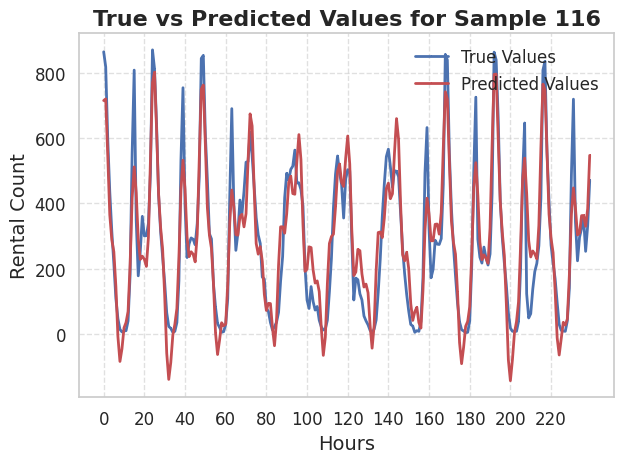

In [54]:
#   画图
sample_idx = 115
# 使用 Seaborn 风格
sns.set(style="whitegrid")
# 绘制真实值
plt.plot(y_true[sample_idx], label='True Values', color='b', linestyle='-', marker=',', markersize=6, linewidth=2)

# 绘制预测值
plt.plot(y_pred[sample_idx], label='Predicted Values', color='r', linestyle='-', marker=',', markersize=6, linewidth=2)

# 添加标题和标签
plt.title(f"True vs Predicted Values for Sample {sample_idx + 1}", fontsize=16, fontweight='bold')
plt.xlabel("Hours", fontsize=14)
plt.ylabel("Rental Count", fontsize=14)

# 设置 x 轴刻度（如果需要）
plt.xticks(np.arange(0, y_train.shape[1], 20), fontsize=12)  # 每 8 个小时一个刻度
# 设置 y 轴刻度
plt.yticks(fontsize=12)

# 添加图例
plt.legend(loc='upper right', fontsize=12, frameon=False)

# 网格线设置（如果需要）
plt.grid(True, linestyle='--', alpha=0.6)

# 保存图像
plt.tight_layout()  # 自动调整布局
plt.savefig(f'true_vs_predicted_sample{sample_idx + 1}_optimized.png')
# 显示图像
plt.show()
